<a href="https://colab.research.google.com/github/natrask/ENM1050/blob/main/Code%20examples/Lecture08_completed_withrunge_kutta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Today we will step through some of the basics of discretizing differential equations to build up simulators of dynamical systems. You can view this as a dry run for the homework due Monday. Unlike the usual lectures, I will step through this and code it in real time from the front of the room, and suggest folks pop open the notebook and type in the same results - you will be able to more or less tweak this to complete Monday's homework. If you feel confident, feel free to grab your partner and work through this in the back of the room on your own, or to jump directly to the homework and work on that.

# Governing equations #

We will consider two systems today:
*   The terminal velocity of a skydiver
*   The nonlinear dynamics of a pendulum

At the whiteboard, I'll derive the following set of governing equations for both

1. $m \ddot{y} = -m g + \frac12 \rho \dot{y}^2 A C_d$, where
  * $m$ is the mass of the skydiver
  * $y,\dot{y}$, and $\ddot{y}$ are the position, velocity, and acceleration of the skydiver, respectively.
  * $\rho$ is the density of the air
  * $A$ is the [projected area](https://en.wikipedia.org/wiki/Projected_area) area of the diver
  * $C_d$ is a coefficient of friction
2. $L \ddot{\theta} = - g \sin \theta$, where
  * $L$ is the length of the pendulum
  * $\theta$ and $\ddot{\theta}$ are the angle and angular acceleration of the pendulum, measured with respect to a vector pointing straight down.
  * $g$ is the acceleration due to gravity.

# Gameplan

We will write code which can solve an equation of the form
$$\dot{y} = F(y,t)$$
$$y(t=0) = y_0$$
where $y \in \mathbb{R}^d$ is a vector valued function. (Interpret this as a sign that you should represent $y$ as a $d \times 1$ numpy array).

First we will implement the explicit Euler method to solve on a time window $t \in [0,t_{final}]$ hardcoded to solve the simple equation
$$\dot{y} = -y$$
For this equation we can check that the solution is
$$y(t) = y_0 \exp(-t)$$

For every problem we will develop *unit tests* confirming that we can recover a known solution, and then use *encapsulation* with functions to show that we can trust our code to generalize to more complicated functions where we don't know the solution.

# The explicit Euler method
We first partition our time domain $[0,t_{final}]$ into $N$ discrete points
$t_i = i \Delta t$, for $i = 0,1,...N-1$ and $\Delta t = t_{final}/(N-1)$. $N$ will be a parameter that we get to choose to set the resolution of our simulation - bigger $N$ will mean a better simulation but it will take longer to run.

In the explicit Euler method, we perform a forward finite difference on the derivative to obtain the following formula centered at the point $t^n$

$$\frac{y^{n+1} - y^n}{\Delta t} = f(y^n,t^n)$$

Mapping into pseudo code

<blockquote>
    Explicit Euler pseudo code

    tvec = build_vector_of_times(N_steps)
    sol[0] = y_0
    for i in 0,...,N_steps:
    f_i = get_f(sol[i],t[i])     # fetch the current value of RHS
    sol[i+1] = sol[i] + dt * f_i # apply update
</blockquote>

Next we'll "hard-code" this to the simple case $\dot{y} =- y$

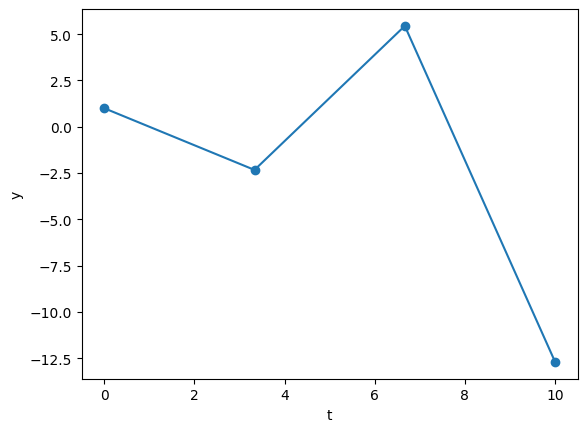

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N_steps = 4
y0 = 1.0

tvec = np.linspace(0.0,10.0,N_steps)
dt = tvec[1] - tvec[0]
sol = np.zeros(N_steps,dtype=np.float64)
sol[0] = y0 # set the initial condition

for i in range(N_steps-1):
    sol[i+1] = sol[i] + dt * (-sol[i])

plt.plot(tvec,sol,'-o')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

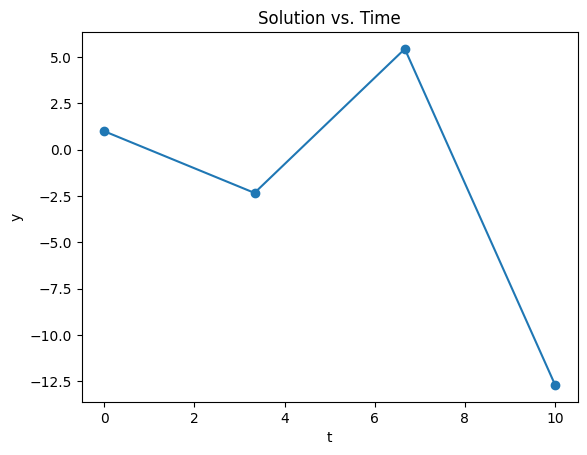

In [2]:
# prompt: generate a plot of the solution versus time

plt.plot(tvec, sol, '-o')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Solution vs. Time')
plt.show()


Let's wrap a function around this, so that we can experiment with how it behaves for different choices of $N$.

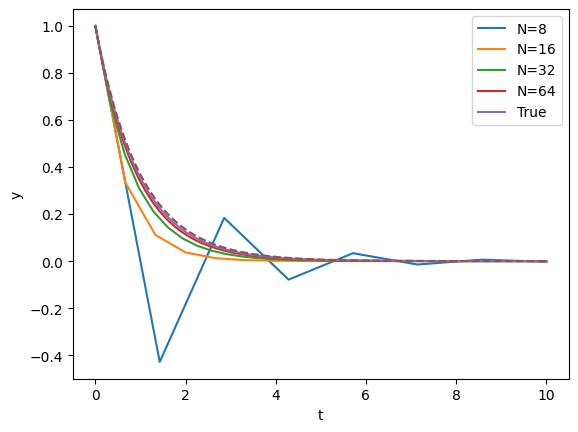

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def solve_ode(N_steps):
  y0 = 1.0

  tvec = np.linspace(0.0,10.0,N_steps)
  dt = tvec[1] - tvec[0]
  sol = np.zeros(N_steps,dtype=np.float64)
  sol[0] = y0 # set the initial condition

  for i in range(N_steps-1):
      sol[i+1] = sol[i] + dt * (-sol[i])

  return [tvec,sol]

plt.figure()
for number_points in [8,16,32,64,128]:
  [t_numpoints,sol_numpoints] = solve_ode(number_points)
  plt.plot(t_numpoints,sol_numpoints,'-')
plt.xlabel('t')
plt.ylabel('y')

ttrue = np.linspace(0.0,10.0,200)
ytrue = np.exp(-ttrue)
plt.plot(ttrue,ytrue,'--')
plt.legend(['N=8','N=16','N=32','N=64','True'])
plt.show()

Now we can experiment easily - we'll generate plots for $N=4,8,16,32,...$ and overlay them over the true solution.

In [4]:
# already did this, whoops

Next I will illustrate how to make a *convergence plot*. This shows how quickly the method recovers the exact solution. For this type of numerical method, error typically scales like:
$$||y-y_{true}|| \sim C \Delta t^\alpha$$
for some choice of $\alpha$ and constant C. Can you infer what the $\alpha$ is for explicit Euler?

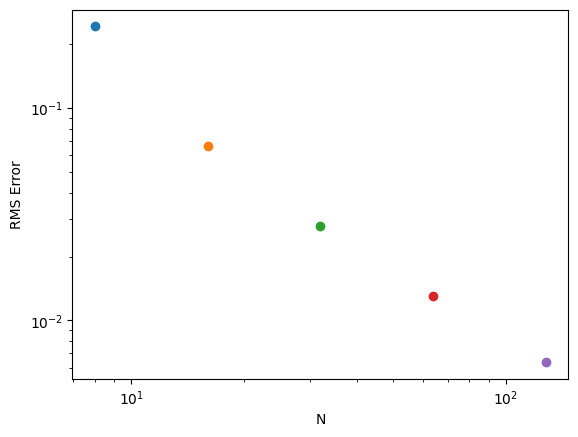

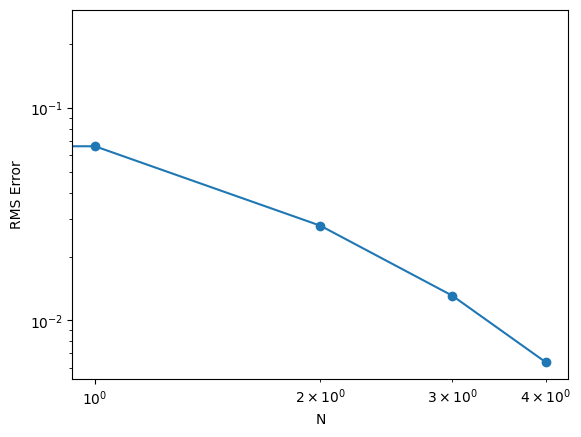

In [5]:
plt.figure()
list_of_errors = []
for number_points in [8,16,32,64,128]:
  [t_numpoints,sol_numpoints] = solve_ode(number_points)
  y_truewnumpoints = np.exp(-t_numpoints)
  err_numpoints = np.abs(sol_numpoints-y_truewnumpoints)
  rms_err_numpoints = np.sqrt(np.mean(err_numpoints**2))
  list_of_errors.append(rms_err_numpoints)
  plt.loglog(number_points,rms_err_numpoints,'o')
plt.xlabel('N')
plt.ylabel('RMS Error')
plt.show()

plt.figure()
plt.loglog(list_of_errors,'-o')
plt.xlabel('N')
plt.ylabel('RMS Error')
plt.show()

Now that we trust our code, we are going to modify it to handle an arbitrary $d$ (i.e. we will handle vector valued solutions) and an arbitrary RHS. We can do this by punching out the line of code that evaluates the RHS and replacing it with a function. We will know we can trust this code when we can reproduce our hard coded initial result.

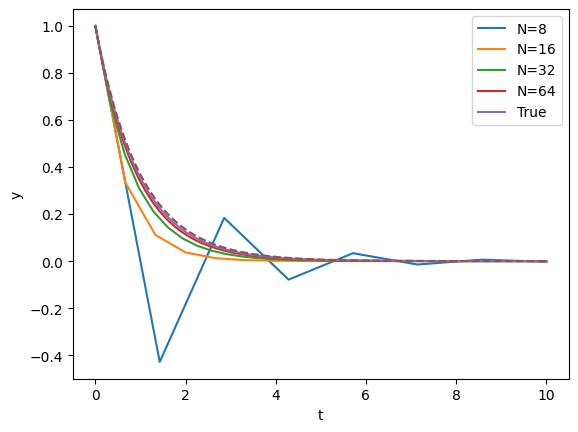

In [6]:
def solve_ode_arbitrary_rhs(N_steps):
  y0 = 1.0

  tvec = np.linspace(0.0,10.0,N_steps)
  dt = tvec[1] - tvec[0]
  sol = np.zeros(N_steps,dtype=np.float64)
  sol[0] = y0 # set the initial condition

  def dydt(y,t):
    return -y

  for i in range(N_steps-1):
      dydt_i = dydt(sol[i],tvec[i])
      sol[i+1] = sol[i] + dt * dydt_i

  return [tvec,sol]

plt.figure()
for number_points in [8,16,32,64,128]:
  [t_numpoints,sol_numpoints] = solve_ode_arbitrary_rhs(number_points)
  plt.plot(t_numpoints,sol_numpoints,'-')
plt.xlabel('t')
plt.ylabel('y')

ttrue = np.linspace(0.0,10.0,200)
ytrue = np.exp(-ttrue)
plt.plot(ttrue,ytrue,'--')
plt.legend(['N=8','N=16','N=32','N=64','True'])
plt.show()

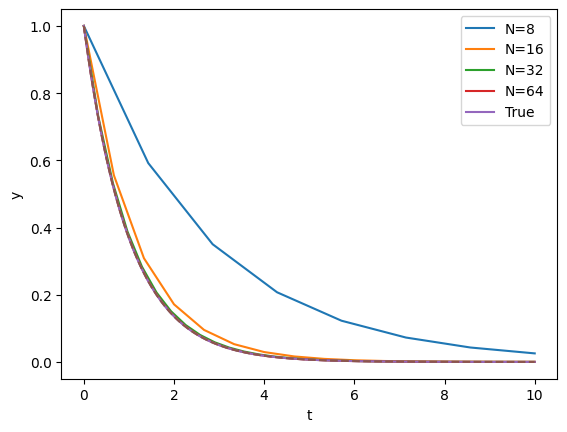

In [7]:
# prompt: replace the previous explicit euler code with a runge-kutta 2 integrator

import numpy as np
import matplotlib.pyplot as plt

def solve_ode_rk2(N_steps):
  y0 = 1.0

  tvec = np.linspace(0.0,10.0,N_steps)
  dt = tvec[1] - tvec[0]
  sol = np.zeros(N_steps,dtype=np.float64)
  sol[0] = y0 # set the initial condition

  def dydt(y,t):
    return -y

  for i in range(N_steps-1):
      k1 = dydt(sol[i], tvec[i])
      k2 = dydt(sol[i] + dt * k1, tvec[i] + dt)
      sol[i+1] = sol[i] + dt * (k1 + k2) / 2

  return [tvec,sol]

plt.figure()
for number_points in [8,16,32,64,128]:
  [t_numpoints,sol_numpoints] = solve_ode_rk2(number_points)
  plt.plot(t_numpoints,sol_numpoints,'-')
plt.xlabel('t')
plt.ylabel('y')

ttrue = np.linspace(0.0,10.0,200)
ytrue = np.exp(-ttrue)
plt.plot(ttrue,ytrue,'--')
plt.legend(['N=8','N=16','N=32','N=64','True'])
plt.show()


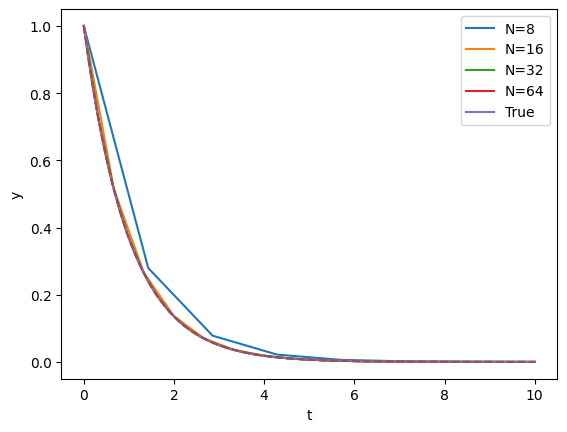

In [8]:
# prompt: repeat the last code but with a runge kutta 4 integrator

def solve_ode_rk4(N_steps):
  y0 = 1.0

  tvec = np.linspace(0.0,10.0,N_steps)
  dt = tvec[1] - tvec[0]
  sol = np.zeros(N_steps,dtype=np.float64)
  sol[0] = y0 # set the initial condition

  def dydt(y,t):
    return -y

  for i in range(N_steps-1):
      k1 = dydt(sol[i], tvec[i])
      k2 = dydt(sol[i] + dt * k1 / 2, tvec[i] + dt / 2)
      k3 = dydt(sol[i] + dt * k2 / 2, tvec[i] + dt / 2)
      k4 = dydt(sol[i] + dt * k3, tvec[i] + dt)
      sol[i+1] = sol[i] + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

  return [tvec,sol]

plt.figure()
for number_points in [8,16,32,64,128]:
  [t_numpoints,sol_numpoints] = solve_ode_rk4(number_points)
  plt.plot(t_numpoints,sol_numpoints,'-')
plt.xlabel('t')
plt.ylabel('y')

ttrue = np.linspace(0.0,10.0,200)
ytrue = np.exp(-ttrue)
plt.plot(ttrue,ytrue,'--')
plt.legend(['N=8','N=16','N=32','N=64','True'])
plt.show()


Finally, we can apply this to our two ODEs. We'll observe however that as written, the equations are written in *second-order form* (i.e. the highest-order derivative in the equation is a 2nd derivative). We will do a trick to turn these into a system of two first-order ODEs.

**The trick:**\\
* Take equation:
  * $m \ddot{y} = -m g + \frac12 \rho \dot{y}^2 A C_d$
* Lump all the parameters so there isn't so much junk to carry around
  * $ \ddot{y} =  \alpha + \beta \dot{y}^2$
  * $\alpha = -g$ and $\beta = \frac{\rho A C_d}{2 m}$
* Define two new variables $y_1$ and $y_2$, where $y_1 = y$ and $\dot{y}_1 = y_2$ - this is equivalent to writing equations governing position and velocity.
* Rewrite to get two equations
  * $\dot{y}_1 = y_2$
  * $\dot{y}_2 =  \alpha + \beta y_2^2$
* Now adopt your solver to take $d=2$ and $F = <y_2, \alpha + \beta y_2^2>$

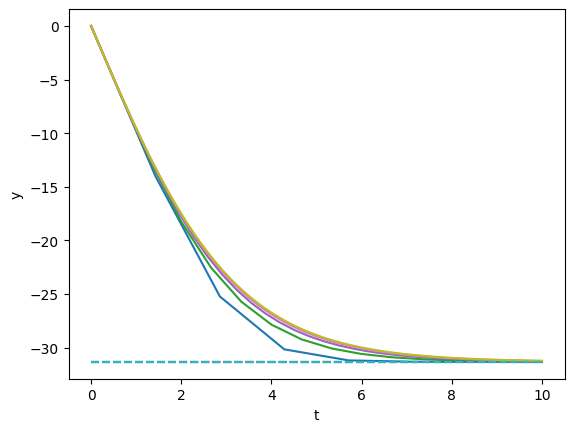

In [ ]:
alpha = -9.81
beta = 0.01

def solve_ode_arbitrary_rhs_second_order(N_steps,d,y0):
  tvec = np.linspace(0.0,10.0,N_steps)
  dt = tvec[1] - tvec[0]
  sol = np.zeros((d,N_steps),dtype=np.float64)
  sol[:,0] = y0 # set the initial condition

  def dydt(y,t):
    dy1dt = y[1] # y[1] refers to y2
    dy2dt = alpha + beta*y[1]**2 # y[1] refers to y2
    return np.array([dy1dt,dy2dt])

  for i in range(N_steps-1):
      dydt_i = dydt(sol[:,i],tvec[i])
      sol[:,i+1] = sol[:,i] + dt * dydt_i

  return [tvec,sol]


for Nsteps in [8,16,32,64,128]:
    [t_numpoints,sol_numpoints] = solve_ode_arbitrary_rhs_second_order(Nsteps,2,np.array([1.0,0.0]))
    steady_state = -np.sqrt(-alpha/beta)
    plt.plot(t_numpoints,sol_numpoints[1,:],'-')
    plt.plot(t_numpoints,steady_state*np.ones(len(t_numpoints)),'--')
    plt.xlabel('t')
    plt.ylabel('y')
plt.show()

To confirm that this is correct, we can look at whether we recover a simple steady state solution of the problem. Setting $\ddot{y}=0$, we arrive at
$$0 =  \alpha + \beta \dot{y_ss}^2$$
or
$$ \dot{y}_{ss} = \sqrt{\frac{-\alpha}{\beta}}$$

Remember that $\alpha$ is defined with a negative sign and $\beta$ is positive, so this is not an imaginary number.

Plot this along with your solution to confirm that you get the correct asymptote.

In [ ]:
# write code here

For a final exercise, you can repeat this for the pendulum case. For that setting, the nonlinear problem doesn't have an exact solution. You can linearize the equation though by approximating $\sin \theta \sim \theta$ to obtain:
$$\ddot{\theta} = - \omega \theta$$
where $\omega = \frac{g}{L}$.

You can confirm that this linearized equation has a solution:
$$\theta(t) = \cos \sqrt{\omega} t$$

This solution is only valid for small $\theta$. If you choose an initial condition that is very small, you'll be able to check that your nonlinear model recovers this limiting behavior.

# ODEInt in SciPy

One final tidbit - there are much better methods for solving ODEs that we will discuss as the class progresses. They typically exploit information about the smoothness of the RHS to obtain answers that require much fewer timesteps - this translates to a higher $\alpha$ in the error convergence. This makes it dangerous to use prepackaged integrators from SciPy; you may be violating some of the assumptions in the method without realizing it (this will happen if you attempt to use odeint for the HW due Monday).

If your RHS is continuous (i.e. you can take as many derivatives you want of it) it is safe to use these packages. To check the syntax, use Gemini to prompt example code that you can adapt to reproduce some of your above results.

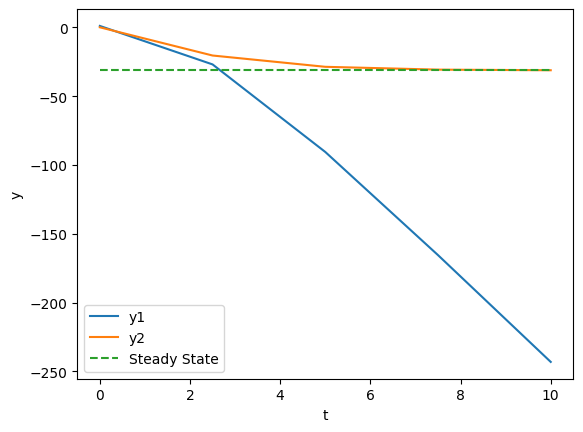

In [ ]:
# prompt: simulate the previous problem odeint in scipy

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

alpha = -9.81
beta = 0.01

def dydt(y, t):
    dy1dt = y[1]
    dy2dt = alpha + beta * y[1]**2
    return [dy1dt, dy2dt]

y0 = [1.0, 0.0]
t = np.linspace(0, 10, 5)
sol = odeint(dydt, y0, t)

plt.plot(t, sol[:, 0], label='y1')
plt.plot(t, sol[:, 1], label='y2')
steady_state = -np.sqrt(-alpha / beta)
plt.plot(t, steady_state * np.ones(len(t)), '--', label='Steady State')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()


# Check your knowledge
Repeat the example on your own (either in class or at home) to confirm that you understand the process and weren't just copying what I put on the screen. Make sure you use *unit tests* to validate your individual components are working correctly.

In [ ]:
# write code here